In [13]:
import torch
import yfinance as yf
import numpy as np
import paddle
import numpy as np
np.object = object
from paddle_quantum.gate import BasisEncoding, AmplitudeEncoding, AngleEncoding, IQPEncoding
import paddle_quantum as pq
import matplotlib.pyplot as plt
from qiskit_machine_learning.utils import algorithm_globals


In [14]:
sp500 = yf.download('^GSPC', start='1992-06-18', end='2024-12-31')
prices = sp500['Close']

# Preprocess the data: calculate returns or normalize directly
log_returns = np.log(prices / prices.shift(1)).dropna()
normalized_data = (log_returns - log_returns.mean()) / log_returns.std()

# Convert to a numpy array for training
training_data = normalized_data.values

qubits = 13

[*********************100%***********************]  1 of 1 completed


[ 0.0061383 +0.j -0.00095556+0.j  0.00120407+0.j ... -0.00070325+0.j
 -0.01096442+0.j -0.01062183+0.j]
<class 'numpy.ndarray'>
8192


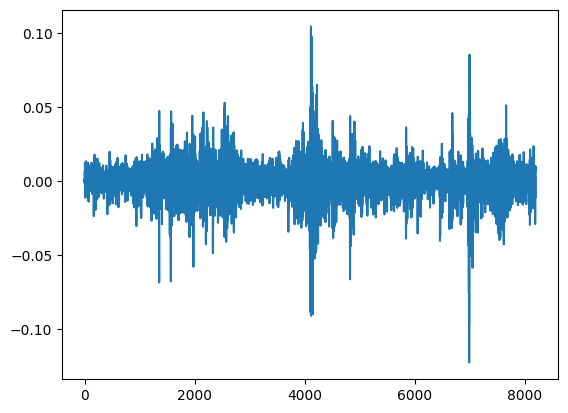

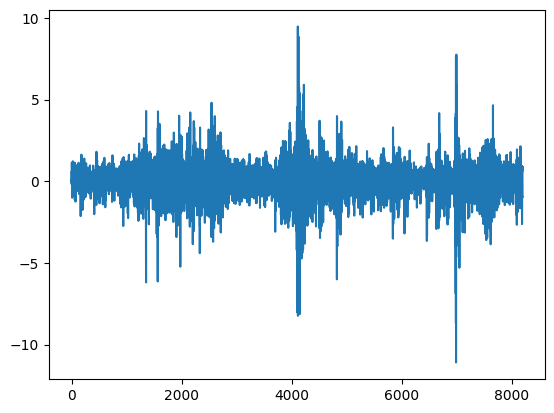

In [15]:
amplitude_enc = AmplitudeEncoding(num_qubits=qubits)
x = paddle.to_tensor(training_data)
state = amplitude_enc(x)
print(state)
data_im = state.numpy().tolist()
data = np.real(data_im)
print(type(data))
print(len(training_data))
plt.plot(data)
plt.show()
plt.plot(training_data)
plt.show()


In [16]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2, NLocal, RealAmplitudes, TwoLocal, QuantumVolume, ExcitationPreserving, QAOAAnsatz

qc = QuantumCircuit(qubits)
# Apply Hadamard gate to all qubits
qc.h(qc.qubits)

reps = 3


# Define ansatz
hardware_efficient = EfficientSU2(qubits, reps=reps)


qc.compose(hardware_efficient, inplace=True)
qc.decompose().draw(output="mpl", style="clifford")
qc.num_parameters

104

In [17]:
from qiskit.primitives import StatevectorSampler as Sampler

sampler = Sampler()

In [18]:
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN


def create_generator() -> TorchConnector:
    qnn = SamplerQNN(
        circuit=qc,
        sampler=sampler,
        input_params=[],
        weight_params=qc.parameters,
        sparse=False,
    )

    initial_weights = algorithm_globals.random.random(qc.num_parameters)
    return TorchConnector(qnn, initial_weights)

In [19]:
from torch import nn


class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 4000)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear2 = nn.Linear(4000,1000)
        self.leaky_relu2 = nn.LeakyReLU(0.2)
        self.linear3 = nn.Linear(1000, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear2(x)
        x = self.leaky_relu2(x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        return x

In [20]:
generator = create_generator()
discriminator = Discriminator(len(data))

[2025-01-09 23:58:03,519] [ WARNING] sampler_qnn.py:262 - No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


In [21]:
def adversarial_loss(input, target, w):
    bce_loss = target * torch.log(input) + (1 - target) * torch.log(1 - input)
    weighted_loss = w * bce_loss
    total_loss = -torch.sum(weighted_loss)
    return total_loss

In [22]:
from torch.optim import Adam

lr = 0.01  # learning rate
b1 = 0.7  # first momentum parameter
b2 = 0.999  # second momentum parameter

generator_optimizer = Adam(generator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)
discriminator_optimizer = Adam(
    discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005
)

In [23]:
from IPython.display import clear_output


def plot_training_progress():
    # we don't plot if we don't have enough data
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # Generator Loss
    ax1.set_title("Loss")
    ax1.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax1.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax1.legend(loc="best")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax1.grid()

    # Relative Entropy
    ax2.set_title("Relative entropy")
    ax2.plot(entropy_values)
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Relative entropy")
    ax2.grid()

    plt.show()

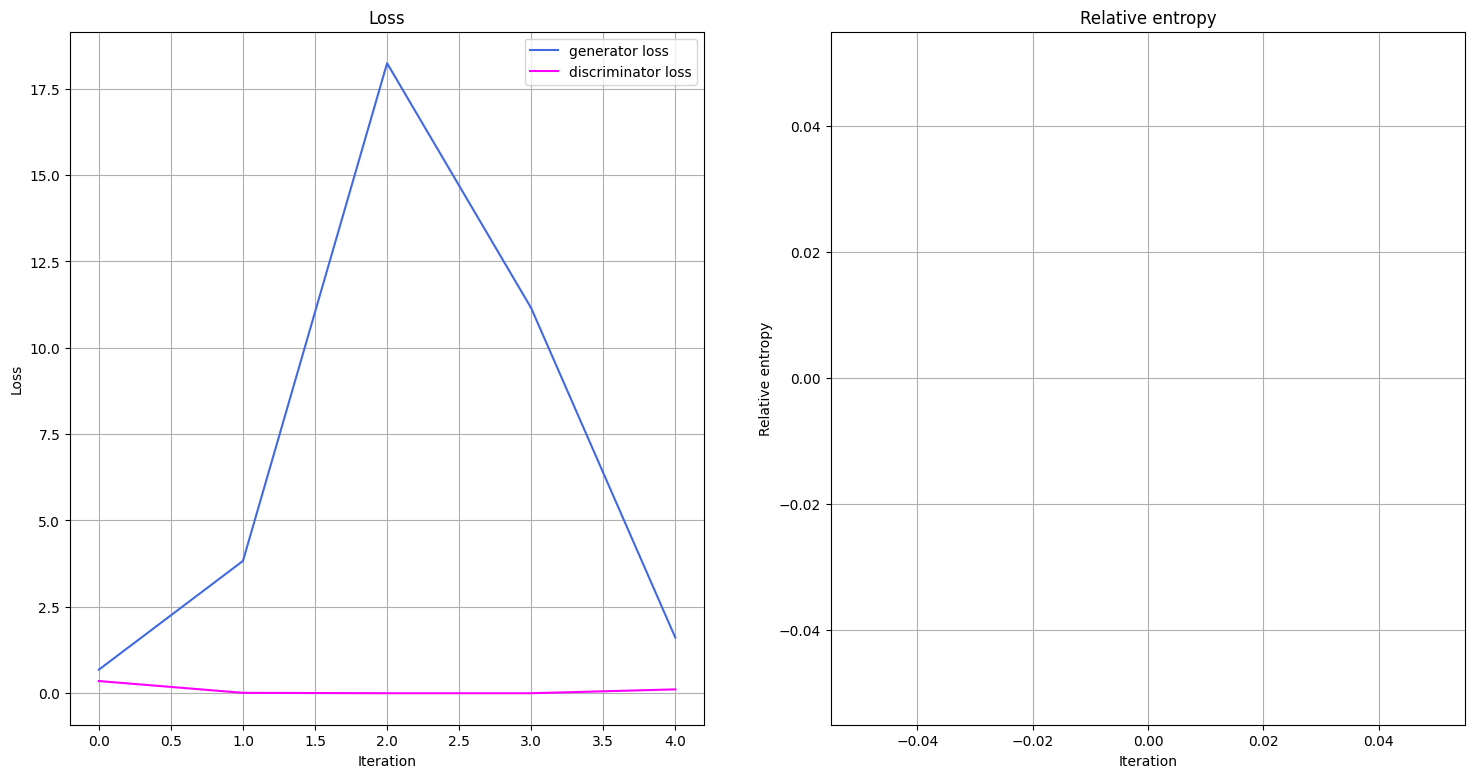

Fit in 109.08 sec
[array([0.00195312, 0.00195312, 0.        , ..., 0.00488281, 0.        ,
       0.00097656], dtype=float32)]


In [24]:
import time
from scipy.stats import entropy

n_epochs = 5
num_discrete_values = len(data)
num_qnn_outputs = num_discrete_values

generator_loss_values = []
discriminator_loss_values = []
entropy_values = []

start = time.time()
for epoch in range(n_epochs):

    valid = torch.ones(num_qnn_outputs, 1, dtype=torch.float)
    fake = torch.zeros(num_qnn_outputs, 1, dtype=torch.float)

    # Configure input
    real_dist = torch.tensor(data, dtype=torch.float).reshape(-1, 1)

    # Configure samples
    samples = torch.tensor(data, dtype=torch.float)
    disc_value = discriminator(samples)

    # Generate data
    gen_dist = generator(torch.tensor([])).reshape(-1,1)

    # Train generator
    generator_optimizer.zero_grad()
    generator_loss = adversarial_loss(disc_value, valid, gen_dist)

    # store for plotting
    generator_loss_values.append(generator_loss.detach().item())

    generator_loss.backward(retain_graph=True)
    generator_optimizer.step()

    # Train Discriminator
    discriminator_optimizer.zero_grad()

    real_loss = adversarial_loss(disc_value, valid, real_dist)
    fake_loss = adversarial_loss(disc_value, fake, gen_dist.detach())
    discriminator_loss = (real_loss + fake_loss) / 2

    # Store for plotting
    discriminator_loss_values.append(discriminator_loss.detach().item())

    discriminator_loss.backward()
    discriminator_optimizer.step()

    gen_data = []
    gen_data.append(gen_dist.detach().squeeze().numpy())

    entropy_value = entropy(gen_dist.detach().squeeze().numpy(), data)
    entropy_values.append(entropy_value)

    print(gen_data)
    
    plot_training_progress()


elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} sec")
print(gen_data)



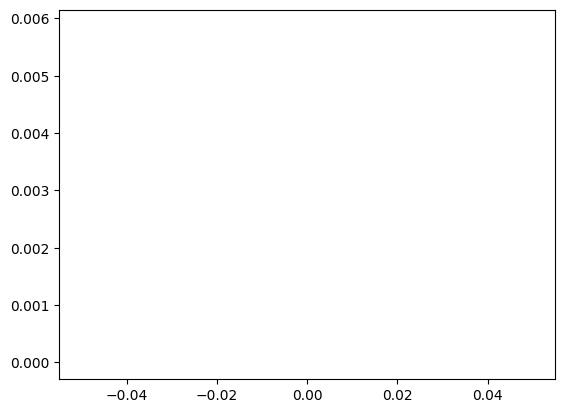

[inf, inf, inf, inf, inf]


In [25]:
plt.plot(gen_data)
plt.show()

print(entropy_values)